In [1]:
# Load modules

import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import zarr
import gcsfs
from scipy.interpolate import griddata
from xmip.preprocessing import rename_cmip6
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import gridspec
import matplotlib
import cartopy as cart
import statistics
from scipy import stats

In [2]:
omega_cont = xr.open_dataarray('/data/keeling/a/mailes2/a/finalized_var_data/CMIP_wap_37model_piControl_2x2_last250.nc')

land_mask = xr.open_dataarray('/data/keeling/a/mailes2/a/finalized_var_data/CMIP_landmask_31model.nc')

tas_cont = xr.open_dataarray('/data/keeling/a/mailes2/a/finalized_var_data/CMIP_tas_piControl_2x2_48mod_last250.nc')

ts_cont = xr.open_dataarray('/data/keeling/a/mailes2/a/finalized_var_data/CMIP_ts_39model_piControl_2x2_last250.nc')

In [3]:
models = ['ACCESS-CM2','ACCESS-ESM1-5','BCC-CSM2-MR','BCC-ESM1','CAMS-CSM1-0','CanESM5','CESM2','CESM2-FV2','CESM2-WACCM',
          'CESM2-WACCM-FV2','CIESM','CMCC-CM2-SR5','CMCC-ESM2','EC-Earth3','EC-Earth3-AerChem','EC-Earth3-CC',
          'EC-Earth3-Veg-LR','FGOALS-f3-L','FGOALS-g3','GFDL-CM4','GFDL-ESM4','GISS-E2-1-G','INM-CM4-8','INM-CM5-0',
          'IPSL-CM5A2-INCA','MIROC6','MPI-ESM1-2-LR','MRI-ESM2-0','NorCPM1','NorESM2-LM','NorESM2-MM','SAM0-UNICON',
          'TaiESM1']

In [4]:
mask = land_mask.mean('name')

In [5]:
omega_cont_tas = omega_cont.sel(name=models).sel(lat=slice(-30,30)).mean('time').mean('name')
omega_cont_ts = omega_cont_tas.where(mask<50)

tas_cont_rolling = tas_cont.sel(name=models).rolling(time=120, center=True).mean('time')
tas_cont_std = tas_cont_rolling.std('time')
tas_cont_var = tas_cont_std.mean('name').sel(lat=slice(-30,30))

ts_cont_rolling = ts_cont.sel(name=models).rolling(time=120, center=True).mean('time')
ts_cont_std = ts_cont_rolling.std('time')
ts_cont_var = ts_cont_std.mean('name').sel(lat=slice(-30,30)).where(mask<50)

In [6]:
bin_edges_tas = np.arange(-0.08,0.08,0.02)
print(bin_edges_tas)

omega_cont_tas_ds = omega_cont_tas.to_dataset()
omega_cont_tas_ds['tas_var'] = tas_cont_var
omega_cont_tas_stack = omega_cont_tas_ds.stack(z=('lat','lon'))
omega_cont_tas_stack['tags_tas'] = pd.cut(omega_cont_tas_stack['wap'], bins=bin_edges_tas, 
                                               labels=bin_edges_tas[:-1])
omega_tas_stats = omega_cont_tas_stack.groupby('tags_tas').groups

# Looking at the bins on a map
omega_tas_unstack = omega_cont_tas_stack.unstack()
omega_tas_unstack['unstacked_tags'] = (('lat','lon'),np.reshape(omega_tas_unstack['tags_tas'].values, (-1,179)))

var_mean_tas = []
var_std_tas = []
for group in omega_tas_stats:
    tas_var_list = []
    for index in omega_tas_stats[group]:
        tas_var_list.append(omega_cont_tas_stack.tas_var[index].item())
    print(statistics.mean(tas_var_list))
    var_mean_tas.append(np.mean(tas_var_list))
    var_std_tas.append(np.std(tas_var_list))

[-8.00000000e-02 -6.00000000e-02 -4.00000000e-02 -2.00000000e-02
  1.38777878e-17  2.00000000e-02  4.00000000e-02  6.00000000e-02]
0.07630964599164751
0.07613151782132499
0.09307302466693479
0.11801043406465674
0.13196300923086535
0.14450264345463254
0.14267958440951362


In [7]:
bin_edges_ts = np.arange(-0.08,0.08,0.02)
print(bin_edges_ts)

omega_cont_ts_ds = omega_cont_ts.to_dataset()
omega_cont_ts_ds['ts_var'] = ts_cont_var
omega_cont_ts_stack = omega_cont_ts_ds.stack(z=('lat','lon'))
omega_cont_ts_stack['tags_ts'] = pd.cut(omega_cont_ts_stack['wap'], bins=bin_edges_ts, 
                                               labels=bin_edges_ts[:-1])
omega_ts_stats = omega_cont_ts_stack.groupby('tags_ts').groups

# Looking at the bins on a map
omega_ts_unstack = omega_cont_ts_stack.unstack()
omega_ts_unstack['unstacked_tags'] = (('lat','lon'),np.reshape(omega_ts_unstack['tags_ts'].values, (-1,179)))

var_mean_ts = []
var_std_ts = []
for group in omega_ts_stats:
    ts_var_list = []
    for index in omega_ts_stats[group]:
        ts_var_list.append(omega_cont_ts_stack.ts_var[index].item())
    print(np.nanmean(ts_var_list))
    var_mean_ts.append(np.nanmean(ts_var_list))
    var_std_ts.append(np.nanstd(ts_var_list))

[-8.00000000e-02 -6.00000000e-02 -4.00000000e-02 -2.00000000e-02
  1.38777878e-17  2.00000000e-02  4.00000000e-02  6.00000000e-02]
0.11762348212417191
0.10844135791008226
0.12384136137121753
0.11925397963980224
0.108138100998313
0.11372617318158293
0.125081142611363


Text(0.5, 1.0, 'CMIP6 piControl TS $\\sigma$ - (N=33)')

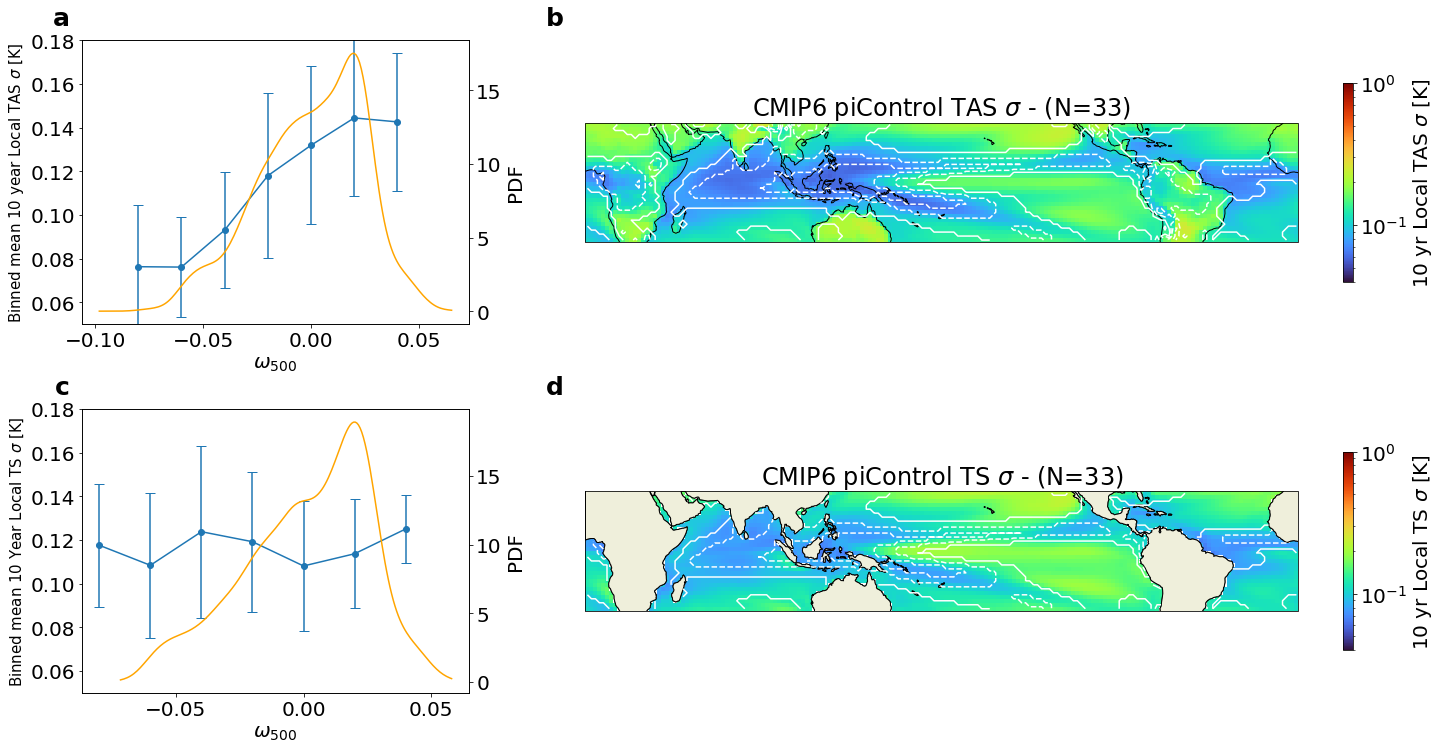

In [9]:
fig = plt.figure(figsize=(25,12))
gs = gridspec.GridSpec(ncols=3, nrows=2)
gs.update(wspace=0.3,hspace=0.3)
#top=300
#bottom=270
font = {'size'   : 20,
        'weight' : 'normal'}

matplotlib.rc('font', **font)

ax1 = fig.add_subplot(gs[0,0])
ax1.errorbar(omega_tas_stats.keys(), var_mean_tas, var_std_tas, capsize=5)
ax1.scatter(omega_tas_stats.keys(), var_mean_tas)
ax1.set_ylabel(r'Binned mean 10 year Local TAS $\sigma$ [K]', fontsize=15)
ax1b = ax1.twinx()
gkde_tas = stats.gaussian_kde(omega_cont_tas_stack['wap'][~np.isnan(omega_cont_tas_stack['wap'])])
tas_pdf = gkde_tas.evaluate(np.linspace(omega_cont_tas_stack['wap'].min(), omega_cont_tas_stack['wap'].max(), 200))
ax1b.plot(np.linspace(omega_cont_tas_stack['wap'].min(), omega_cont_tas_stack['wap'].max(), 200), tas_pdf, color='orange')
ax1b.set_ylabel(r'PDF')
ax1.set_xlabel(r'$\omega_{500}$')
ax1.set_ylim(0.05, 0.18)
ax1.text(-0.03, 1.12, 'a', transform=ax1.transAxes,
      fontsize=25, fontweight='bold', va='top', ha='right')

ax2 = fig.add_subplot(gs[0,1:3], projection=ccrs.PlateCarree(central_longitude=180))
tas_cont_var.plot(ax=ax2, transform=ccrs.PlateCarree(), cmap='turbo', vmin=4*10e-3, vmax=1, 
                   norm=matplotlib.colors.LogNorm(), cbar_kwargs={'label': r"10 yr Local TAS $\sigma$ [K]",
                                                                  'shrink': 0.7
                                                                  })
ax2.coastlines(color='black', linewidth=1)
omega_tas_unstack['unstacked_tags'].plot.contour(ax=ax2, transform=ccrs.PlateCarree(), colors='w')
ax2.set_title(r'CMIP6 piControl TAS $\sigma$ - (N=33)')
ax2.text(-0.03, 1.97, 'b', transform=ax2.transAxes,
      fontsize=25, fontweight='bold', va='top', ha='right')

ax3 = fig.add_subplot(gs[1,0])
ax3.errorbar(omega_ts_stats.keys(), var_mean_ts, var_std_ts, capsize=5)
ax3.scatter(omega_ts_stats.keys(), var_mean_ts)
ax3.set_ylabel(r'Binned mean 10 Year Local TS $\sigma$ [K]', fontsize=15)
ax3b = ax3.twinx()
gkde_ts = stats.gaussian_kde(omega_cont_ts_stack['wap'][~np.isnan(omega_cont_ts_stack['wap'])])
ts_pdf = gkde_ts.evaluate(np.linspace(omega_cont_ts_stack['wap'].min(), omega_cont_ts_stack['wap'].max(), 200))
ax3b.plot(np.linspace(omega_cont_ts_stack['wap'].min(), omega_cont_ts_stack['wap'].max(), 200), ts_pdf, color='orange')
ax3b.set_ylabel('PDF')
ax3.set_xlabel(r'$\omega_{500}$')
ax3.set_ylim(0.05, 0.18)
ax3.text(-0.03, 1.12, 'c', transform=ax3.transAxes,
      fontsize=25, fontweight='bold', va='top', ha='right')

ax4 = fig.add_subplot(gs[1,1:3], projection=ccrs.PlateCarree(central_longitude=180))
ts_cont_var.plot(ax=ax4, transform=ccrs.PlateCarree(), cmap='turbo', vmin=4*10e-3, vmax=1, 
                 norm=matplotlib.colors.LogNorm(), cbar_kwargs={'label': r"10 yr Local TS $\sigma$ [K]",
                                                                'shrink': 0.7})
ax4.coastlines(color='black', linewidth=1)
ax4.add_feature(cart.feature.LAND, zorder=2, edgecolor='k')
omega_ts_unstack['unstacked_tags'].plot.contour(ax=ax4, transform=ccrs.PlateCarree(), colors='w')
ax4.text(-0.03, 1.97, 'd', transform=ax4.transAxes,
      fontsize=25, fontweight='bold', va='top', ha='right')
ax4.set_title(r'CMIP6 piControl TS $\sigma$ - (N=33)')

In [46]:
tas_cont_var_mask = tas_cont_var.where(mask<50)

In [51]:
bin_edges_tas = np.arange(-0.08,0.08,0.02)
print(bin_edges_tas)

omega_cont_tas_ds = omega_cont_ts.to_dataset()
omega_cont_tas_ds['tas_var'] = tas_cont_var_mask
omega_cont_tas_stack = omega_cont_tas_ds.stack(z=('lat','lon'))
omega_cont_tas_stack['tags_tas'] = pd.cut(omega_cont_tas_stack['wap'], bins=bin_edges_tas, 
                                               labels=bin_edges_tas[:-1])
omega_tas_stats = omega_cont_tas_stack.groupby('tags_tas').groups

# Looking at the bins on a map
omega_tas_unstack = omega_cont_tas_stack.unstack()
omega_tas_unstack['unstacked_tags'] = (('lat','lon'),np.reshape(omega_tas_unstack['tags_tas'].values, (-1,179)))

var_mean_tas = []
var_std_tas = []
for group in omega_tas_stats:
    tas_var_list = []
    for index in omega_tas_stats[group]:
        tas_var_list.append(omega_cont_tas_stack.tas_var[index].item())
    print(np.nanmean(tas_var_list))
    var_mean_tas.append(np.nanmean(tas_var_list))
    var_std_tas.append(np.nanstd(tas_var_list))

[-8.00000000e-02 -6.00000000e-02 -4.00000000e-02 -2.00000000e-02
  1.38777878e-17  2.00000000e-02  4.00000000e-02  6.00000000e-02]
0.09193273610955525
0.09224674093288822
0.11073493825478672
0.1083194751467223
0.0987887654664293
0.10542972625851786
0.12062349424988364


Text(0.5, 1.0, 'CMIP6 piControl TS $\\sigma$ - (N=33)')

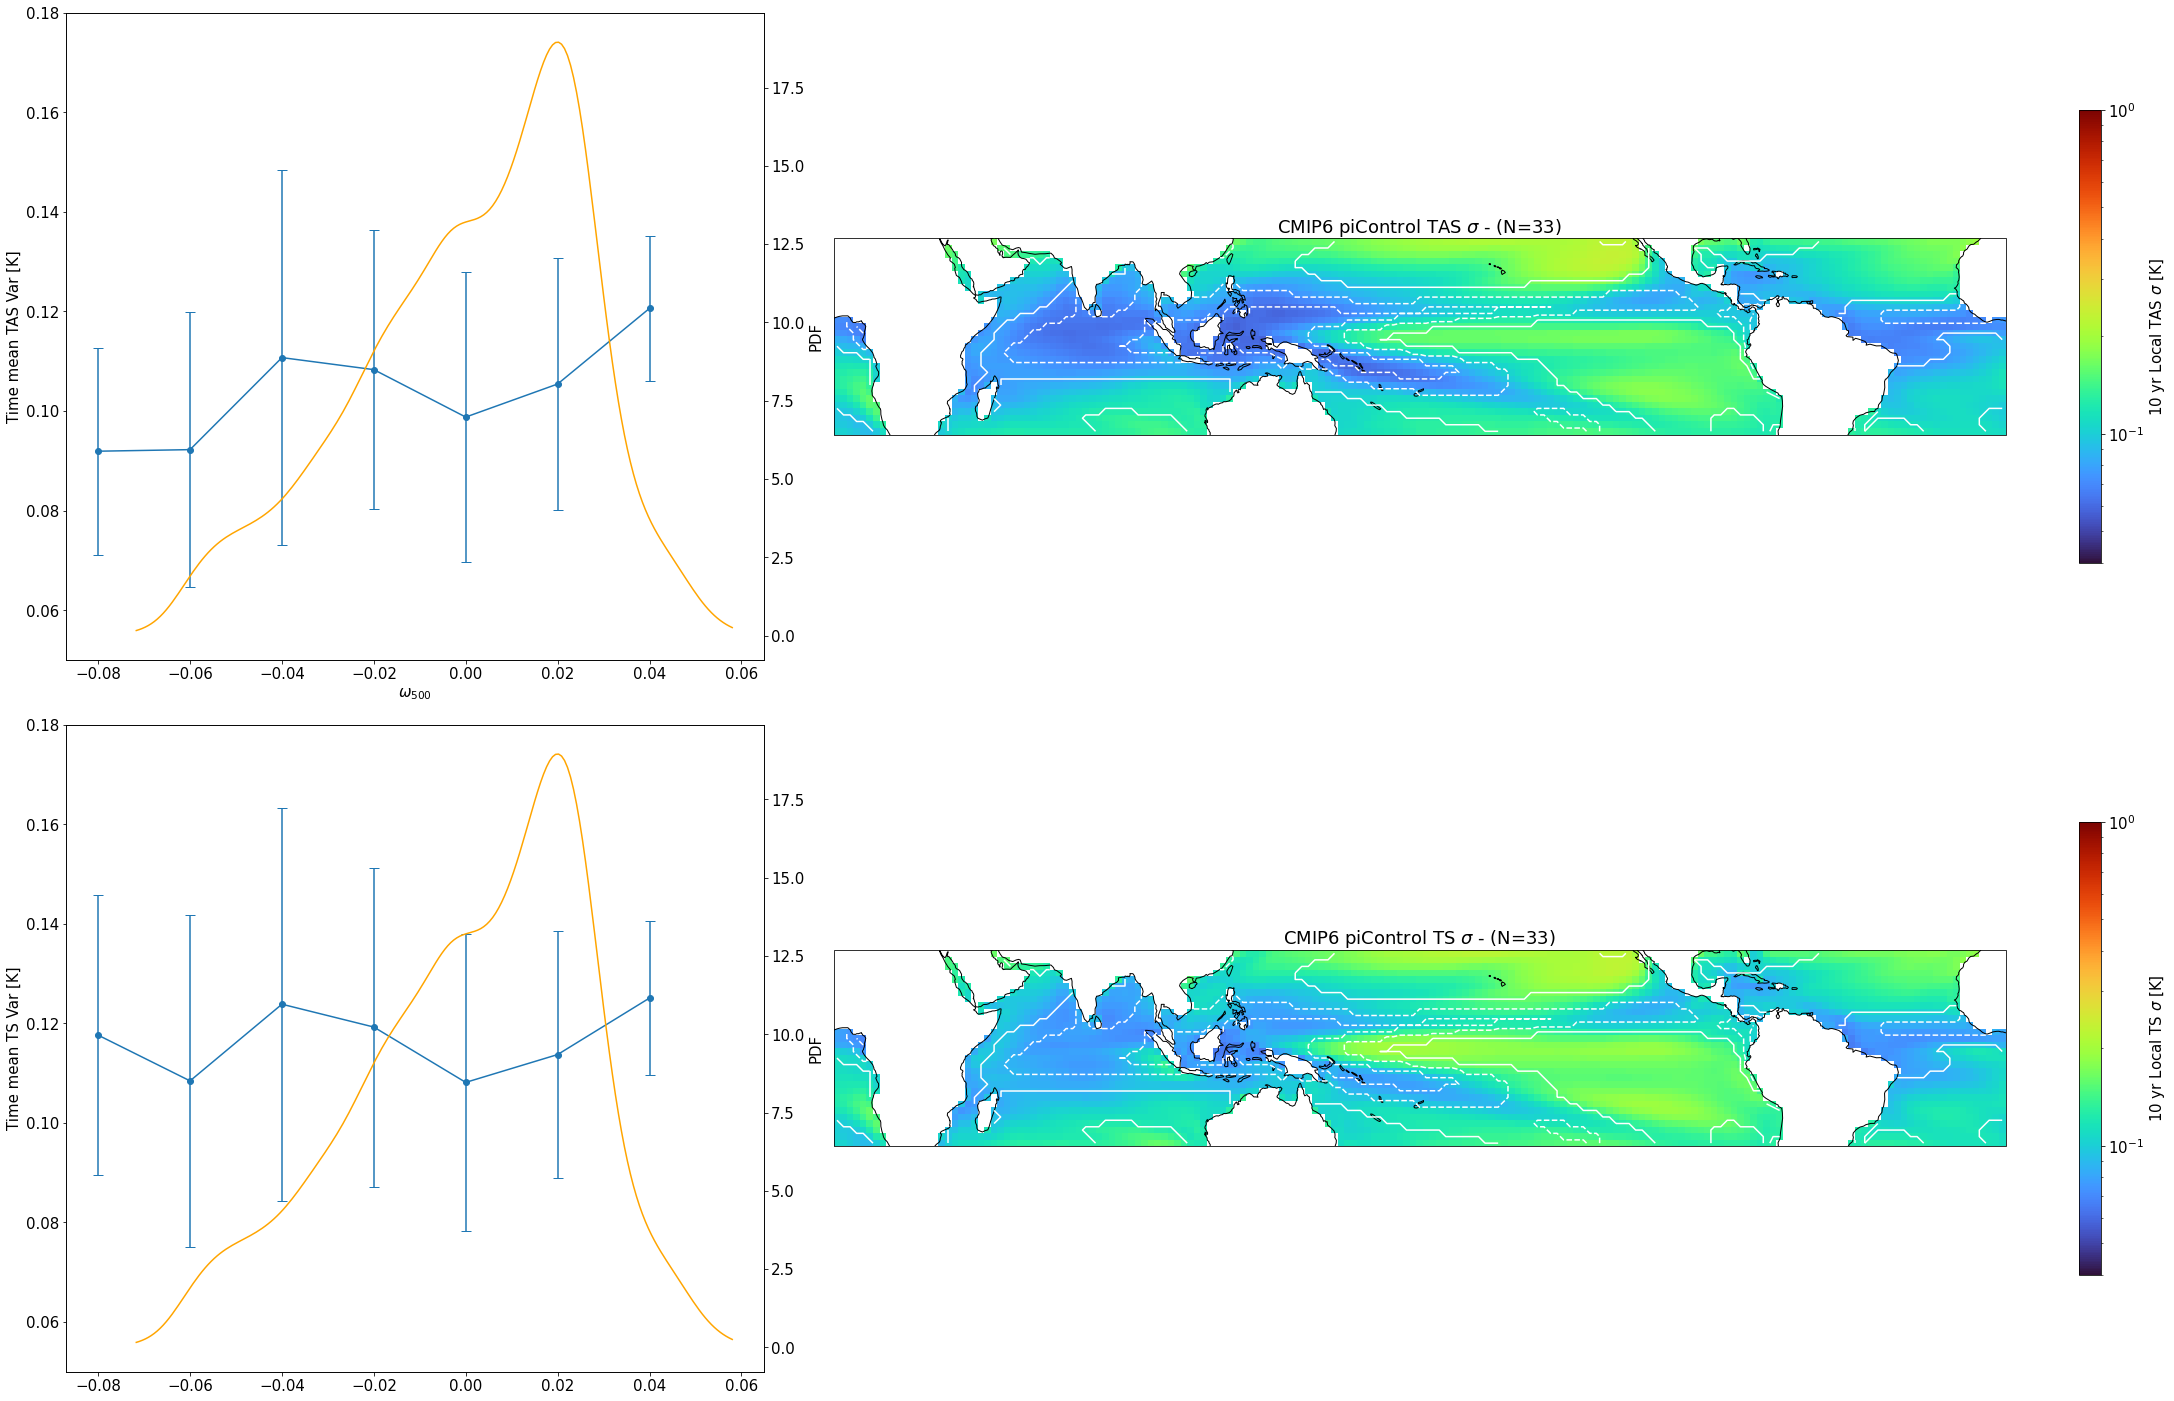

In [53]:
fig = plt.figure(figsize=(40,25))
gs = gridspec.GridSpec(ncols=3, nrows=2)
gs.update(wspace=0.1,hspace=0.1)
#top=300
#bottom=270
font = {'size'   : 15,
        'weight' : 'normal'}

matplotlib.rc('font', **font)

ax1 = fig.add_subplot(gs[0,0])
ax1.errorbar(omega_tas_stats.keys(), var_mean_tas, var_std_tas, capsize=5)
ax1.scatter(omega_tas_stats.keys(), var_mean_tas)
ax1.set_ylabel('Time mean TAS Var [K]')
ax1b = ax1.twinx()
gkde_tas = stats.gaussian_kde(omega_cont_tas_stack['wap'][~np.isnan(omega_cont_tas_stack['wap'])])
tas_pdf = gkde_tas.evaluate(np.linspace(omega_cont_tas_stack['wap'].min(), omega_cont_tas_stack['wap'].max(), 200))
ax1b.plot(np.linspace(omega_cont_tas_stack['wap'].min(), omega_cont_tas_stack['wap'].max(), 200), tas_pdf, color='orange')
ax1b.set_ylabel(r'PDF')
ax1.set_xlabel(r'$\omega_{500}$')
ax1.set_ylim(0.05, 0.18)

ax2 = fig.add_subplot(gs[0,1:3], projection=ccrs.PlateCarree(central_longitude=180))
tas_cont_var_mask.plot(ax=ax2, transform=ccrs.PlateCarree(), cmap='turbo', vmin=4*10e-3, vmax=1, 
                   norm=matplotlib.colors.LogNorm(), cbar_kwargs={'label': r"10 yr Local TAS $\sigma$ [K]",
                                                                  'shrink': 0.7
                                                                  })
ax2.coastlines(color='black', linewidth=1)
omega_tas_unstack['unstacked_tags'].plot.contour(ax=ax2, transform=ccrs.PlateCarree(), colors='w')
ax2.set_title(r'CMIP6 piControl TAS $\sigma$ - (N=33)')


ax3 = fig.add_subplot(gs[1,0])
ax3.errorbar(omega_ts_stats.keys(), var_mean_ts, var_std_ts, capsize=5)
ax3.scatter(omega_ts_stats.keys(), var_mean_ts)
ax3.set_ylabel('Time mean TS Var [K]')
ax3b = ax3.twinx()
gkde_ts = stats.gaussian_kde(omega_cont_ts_stack['wap'][~np.isnan(omega_cont_ts_stack['wap'])])
ts_pdf = gkde_ts.evaluate(np.linspace(omega_cont_ts_stack['wap'].min(), omega_cont_ts_stack['wap'].max(), 200))
ax3b.plot(np.linspace(omega_cont_ts_stack['wap'].min(), omega_cont_ts_stack['wap'].max(), 200), ts_pdf, color='orange')
ax3b.set_ylabel('PDF')
ax3b.set_xlabel(r'$\omega_{500}$')
ax3.set_ylim(0.05, 0.18)

ax4 = fig.add_subplot(gs[1,1:3], projection=ccrs.PlateCarree(central_longitude=180))
ts_cont_var.plot(ax=ax4, transform=ccrs.PlateCarree(), cmap='turbo', vmin=4*10e-3, vmax=1, 
                 norm=matplotlib.colors.LogNorm(), cbar_kwargs={'label': r"10 yr Local TS $\sigma$ [K]",
                                                                'shrink': 0.7})
ax4.coastlines(color='black', linewidth=1)
omega_ts_unstack['unstacked_tags'].plot.contour(ax=ax4, transform=ccrs.PlateCarree(), colors='w')
ax4.set_title(r'CMIP6 piControl TS $\sigma$ - (N=33)')